# Lab -- Period of a Pendulum

**Please write your name in this box**

*We encourage you to work together, and seek whatever help you need in completing this lab.  Please list all people who you worked with or received help from*

*We encourage you to use any online resources that you find useful. Please list any URL's that you consulted*

*We encourage you to use AI resources if you find them useful.  If you made use of AI, please list the platform and the prompts which you made use of*

## Some basics of working with notebooks

This is a Jupyter notebook:  it is an interactive interface with Julia, which is similar to Mathematica.  

There are two types of cells: *Markdown* and *code*.  Markdown cells understand $\LaTeX$ -- and you can insert arbitrary html commants in them -- meaning that if you upload an image to your Google Drive, and make it world readible, you can insert it into the cell.  Markdown cells also accept standard *Markdown* syntax.

In code cells, but not markdown cells, you can type Greek letters by typing their LaTeX name -- such as `\alpha` and then hit`tab`.  Subscripts, $f_j$, can be written as `f\_j` followed by `tab`.

You click on a markdown cell to edit it -- typeset it with a "shift-enter".  To run a code cell type shift-enter on it. 

Here are some useful links:
- [Getting Started with Julia](https://computationalthinking.mit.edu/Spring21/basic_syntax/)
- [Fasttrack to Julia](https://juliadocs.github.io/Julia-Cheat-Sheet/)
- [MATLAB-Julia-Python comparison](https://cheatsheets.quantecon.org/)
- [Plots.jl cheatsheet](https://github.com/sswatson/cheatsheets/blob/master/plotsjl-cheatsheet.pdf)

Rather than spending time teaching you a bunch of syntax in the abstract -- we will try to pick up syntax on-the-go.  It is great practice to use google and stack overflow to figure out notation

<h3 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:blue; color:white;" >warm-up on data entry</h3>

**Hit shift-enter on each of these lines sequentially to run the code.  Then change $\alpha$ to $\beta$, change the numbers, and rerun**  

In [1]:
α=1

1

In [2]:
α+3

4

### Getting Help

Want to know what a symbol means?  For example, what is does the `length` command do?  Type `?length` and then shift-enter. 

In [3]:
?length

search: length



```
length(collection) -> Integer
```

Return the number of elements in the collection.

Use [`lastindex`](@ref) to get the last valid index of an indexable collection.

See also: [`size`](@ref), [`ndims`](@ref), [`eachindex`](@ref).

# Examples

```jldoctest
julia> length(1:5)
5

julia> length([1, 2, 3, 4])
4

julia> length([1 2; 3 4])
4
```

---

```
length(A::AbstractArray)
```

Return the number of elements in the array, defaults to `prod(size(A))`.

# Examples

```jldoctest
julia> length([1, 2, 3, 4])
4

julia> length([1 2; 3 4])
4
```

---

```
length(s::AbstractString) -> Int
length(s::AbstractString, i::Integer, j::Integer) -> Int
```

Return the number of characters in string `s` from indices `i` through `j`.

This is computed as the number of code unit indices from `i` to `j` which are valid character indices. With only a single string argument, this computes the number of characters in the entire string. With `i` and `j` arguments it computes the number of indices between `i` and `j` inclusive that are valid indices in the string `s`. In addition to in-bounds values, `i` may take the out-of-bounds value `ncodeunits(s) + 1` and `j` may take the out-of-bounds value `0`.

!!! note
    The time complexity of this operation is linear in general. That is, it will take the time proportional to the number of bytes or characters in the string because it counts the value on the fly. This is in contrast to the method for arrays, which is a constant-time operation.


See also [`isvalid`](@ref), [`ncodeunits`](@ref), [`lastindex`](@ref), [`thisind`](@ref), [`nextind`](@ref), [`prevind`](@ref).

# Examples

```jldoctest
julia> length("jμΛIα")
5
```


## Logging and Debugging

Here is a quick intro to `logging` in Julia, as a way to help your coding.

In [4]:
# Set up a logger, which we can use for debug messages
using Logging
debug_logger=ConsoleLogger(stderr, Logging.Debug);

In [5]:
function addnumbers(a,b)
    @debug "addnumbers called with arguments" a b
    result=a+b
    @debug "calculated result as" result
    return result
end

addnumbers (generic function with 1 method)

Under normal evaluation those `@debug` statements are essentially ignored.  They should not greatly affect the code speed, so feel free to liberally add them.  You can always remove them later.

In [6]:
addnumbers(2,3)

5

When you wrap your code inside a `with_logger` environment the debug messages are sent to `stderr` -- which in a Jupyter notebook appears in a red box.

In [7]:
with_logger(debug_logger) do # Enable the debug logger locally
    addnumbers(2,3)
end

┌ Debug: addnumbers called with arguments
│   a = 2
│   b = 3
└ @ Main In[5]:2
┌ Debug: calculated result as
│   result = 5
└ @ Main In[5]:4


5

You can turn on/off the display line numbers with the option in the `View` menu

### Group Debugging

Having trouble with some code?  I will circulate to help you.  Post the problem code to *Ed Discussions* (linked through the Canvas site), and we can debug it as a class. This is a great way to work on debugging skills.

# Introduction

In our first lecture we developed tools for numerical integration, with the goal of being able to calculate the period of the pendulum using

$$
\bar T =\frac{T}{T_0}=\frac{\sqrt{2}}{\pi}\int_0^{\theta_m}\frac{d\theta}{\sqrt{\cos(\theta)-\cos(\theta_m)}}
$$
where
$$
T_{0}=2\pi \frac{L}{g}.
$$

We developed tools to use the Trapezoid Rule to carry out integration like this.  Unfortunately these tools will not directly work here, because the integrand diverges.  In this lab you will explore two complementary ways to get around this problem:

1. **Midpoint Rule:**  You will develop code which will calculate the period using an algorithm that does not require evaluating the integrand at the end points.
2. **Change of variables:** You will introduce a change of variables which eliminates the divergence.

By itself, using the midpoint rule will not suffice to solve our problems, as the resulting numerical integral will converge very slowly.  The change of variables, however, will accelerate convergence.  

After solving the technical problems, you will try to understand the behavior of period.

In [8]:
using Plots,LaTeXStrings #load in visualization software

If you want to use interactive widgets (requires using Classic Notebooks), uncomment the next line.  (You shouldn't need this)

In [9]:
# using Interact

# Midpoint Rule

The midpoint rule involves breaking an integral into a series of rectangles.  Here is some code that generates an illustrative diagram

In [10]:
"""
    showmidpoint(f,range=(0,1),n=5;opts...)

Illustrates midpoint rule by plotting the function `f` over the range specified by `range`.
Show `n` rectangles overlayed.  Passes on options `opts` to the plot command.
"""
function showmidpoint(f,range=(0,1),n=5;opts...)
    # define variables
    xmin=range[1]
    xmax=range[2]
    # Create basic plot of function
    plt=plot(f,xmin,xmax,xlabel="x",ylabel="f",legend=false,show=false,opts...)
    #
    # Draw rectangles
    #
    function rectangle(j)
        width=(xmax-xmin)/n
        x1=(j-1)*width
        x2=j*width
        y1=f((x1+x2)/2)
        y2=y1
        Shape([x1, x1, x2, x2],[0,y1,y2,0])
    end
    for j in 1:n
        plot!(rectangle(j),opacity=0.2)
    end
    plt
end

showmidpoint

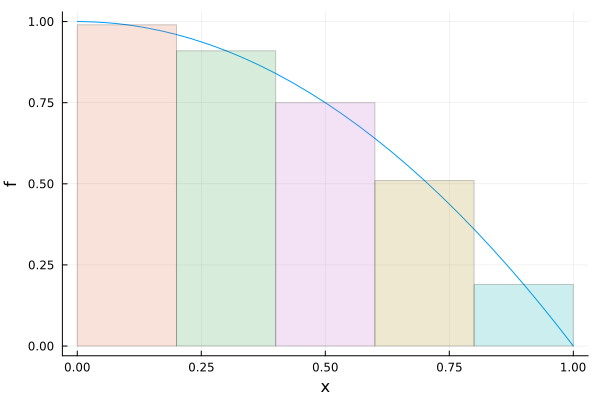

In [11]:
showmidpoint(x->1-x^2,(0,1),5)

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 1
</h2>

Looking back at the lecture notes, create a function `naive_midpoint` which is called with `naive_midpoint(f,(a,b),n)`.  This approximates the integral of `f` on the interval `(a,b)`, using the midpoint rule with `n` rectangles.

Add as many cells as needed.  Test it on some simple functions: flat, linear, quadratic, cubic.  Make sure to also Clean up the notebook, but leave all your tests in, so that you have a record of checking it.  Add markdown cells as needed to document what you are doing.

In [12]:
# My Solution -- remove this line before posting
#
"""
    naive_midpoint(f,range,n)

is a naive implementation of the midpoint rule for calculating
`∫f(x)dx`, with `x` running between `a` and `b` where `range=(a,b)`.
The integral region is divided into `n` rectangles.
"""
function naive_midpoint(f,range,n)
    result=0.
    xmin=range[1]
    xmax=range[2]
    dx=(xmax-xmin)/n
    for j in 1:n
        x=xmin+(j-1/2)*dx
        result+= f(x)*dx
    end
    return result
end

naive_midpoint

In [13]:
# My Test -- remove this line before posting
(naive_midpoint(x->1,(5,10),4),5.)

(5.0, 5.0)

In [14]:
# My Test -- remove this line before posting
(naive_midpoint(x->x,(1,10),4),(10^2-1^2)/2)

(49.5, 49.5)

In [15]:
# My Test -- remove this line before posting
(naive_midpoint(x->x^2,(5,10),100),(10^3-5^3)/3)

(291.6656250000001, 291.6666666666667)

In [16]:
# My Test -- remove this line before posting
(naive_midpoint(x->x^3,(10,100),100),(100^4-10^4)/4)

(2.4996497625000007e7, 2.49975e7)

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 2
</h2>

We want to know how the error varies with `n`.  Following the procedure we did in lecture (or another sensible approach), take a sample function and plot the error vs `n`.  Rescale axes to demonstrate that it is a power law, and find the power law.  Label your axes.  Add extra cells as needed.

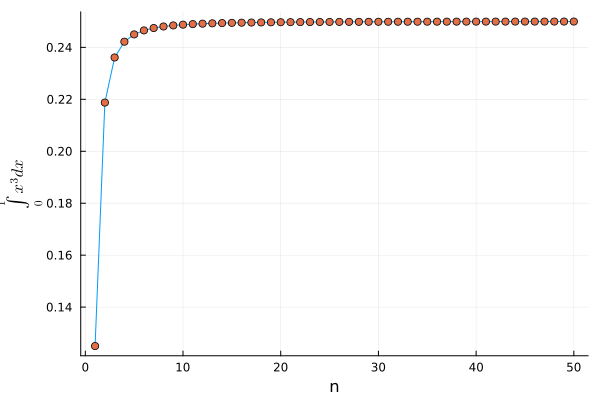

In [17]:
# My solution
nvals=1:50
tvals=[naive_midpoint(x->x^3,(0,1),n) for n in nvals]
plot(nvals,tvals,xlabel="n",ylabel=L"$\int_0^1x^3dx$",legend=false)
scatter!(nvals,tvals)

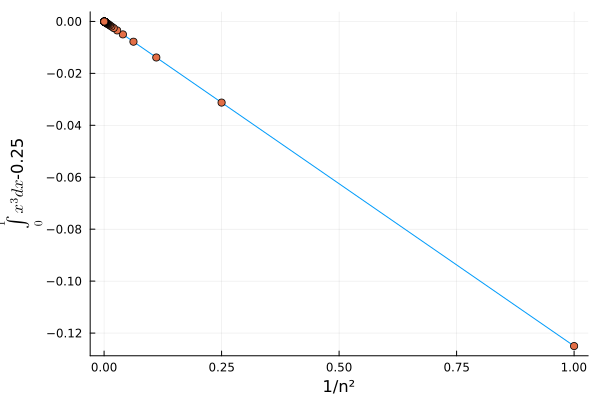

In [18]:
# My solution
plot(1 ./nvals.^2,tvals.-0.25,xlabel="1/n²",ylabel=L"$\int_0^1x^3dx$-0.25",legend=false)
scatter!(1 ./nvals.^2,tvals.-0.25)

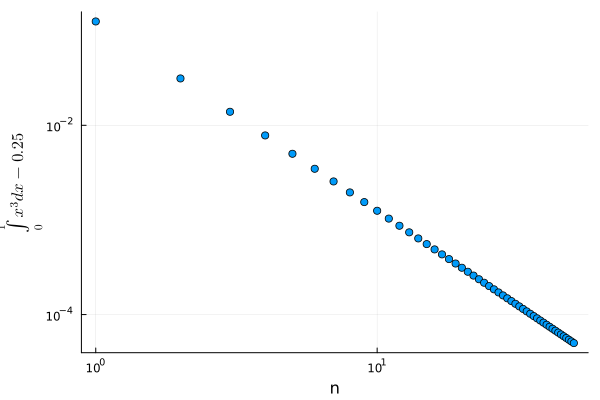

In [19]:
# My solution
scatter(nvals,abs.(tvals.-0.25),xlabel="n",ylabel=L"$\int_0^1x^3dx-0.25$",
    legend=false,xaxis=:log, yaxis=:log)

In [20]:
# my solution
"""
    linearfit(X,Y,functions)

takes a set of `X=(x1,x2,...xn)`, `Y=(y1,y1,...yn)` and a set of `functions=(f1, f2,...fm)` 
and returns the set of coefficients `C=(c1,c2,..cm)` which minimize 


         n       m
    χ²=  ∑  (yi- ∑  cj fj(xi))^2
        i=1     j=1

It is implemented by constructing the `n×m` matrix `A` with matrix elements

    Aᵢⱼ= fj(xi)

then `(AᵗA)C=AᵗY`, where `Y=(y1,y2,...yn)`.  Thus the optimal coefficients are 
`(AᵗA)⁻¹(AᵗY)`, which can be implemented with `(AᵗA)\\(AᵗY)`.
"""
function linearfit(X,Y,functions)
    A=[f(x) for x in X, f in functions ]
    return transpose(A)*A\(transpose(A)*Y) # This is equivalent to (AᵗA)⁻¹(AᵗY)
end                                        # the "\" is "divide from left"

linearfit

In [21]:
#my solution
lf1=linearfit(log.(nvals),log.(abs.(tvals.-0.25)),(x->1.,x->x))

2-element Vector{Float64}:
 -2.079441541680057
 -1.9999999999998808

Again it looks like the error scales as $n^{-2}$

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 3
</h2>

As with the trapezoid rule, it would be nice not to have to give the integrator the parameter `n`.  We can use the same strategy for subdividing.  One small change is that if you double the number of rectangles, none of the midpoints are the same.  On the other hand, if you triple the number of rectangles, then you can reuse the old data.

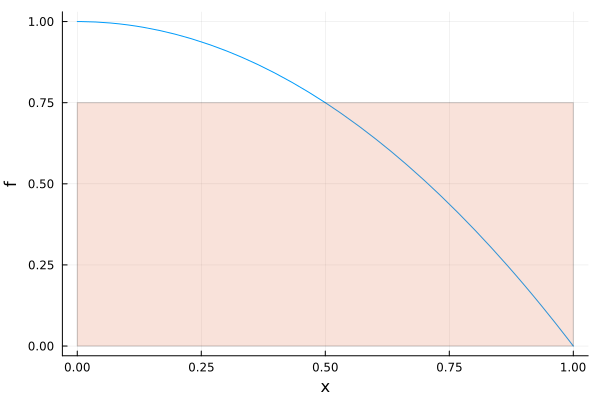

In [22]:
showmidpoint(x->1-x^2,(0,1),1)

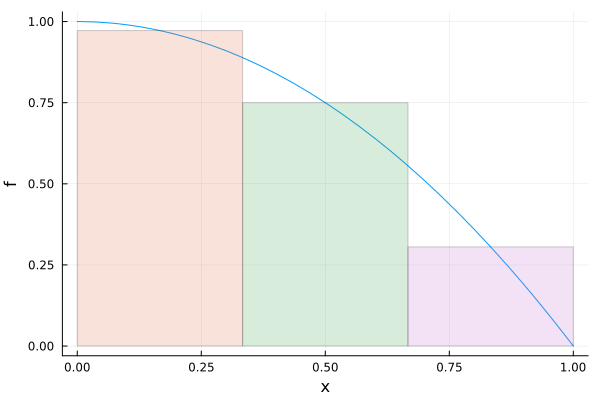

In [23]:
showmidpoint(x->1-x^2,(0,1),3)

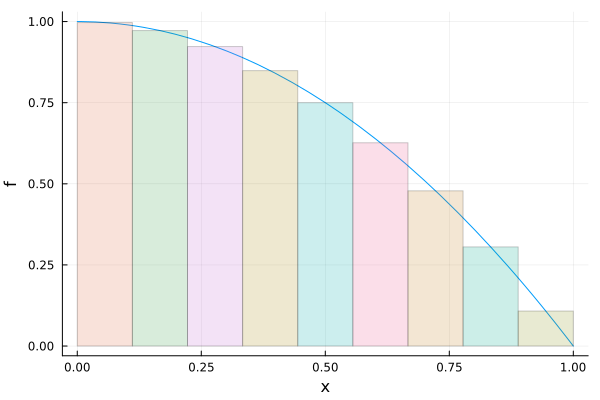

In [24]:
showmidpoint(x->1-x^2,(0,1),9)

Thus it is natural to use a data structure `mid_data`

In [25]:
"""
    mid_data(f,range)

stores the intermediate information for our midpoint rule. 

Fields:
    f       # store the function we are integrating
    range   # store the range (a,b)
    val     # midpoint rule integral at current depth, m
    oldval  # midpoint rule integral at previous depth, m-1
    m       # depth -- number of rectangles = 3ᵐ

To increase the depth use command `subdivide!`.

"""
mutable struct mid_data
    f       # store the function we are integrating
    range   # store the range (a,b)
    val     # midpoint rule integral at current depth, m
    m ::Integer      # depth -- number of rectangles = 3ᵐ
    function mid_data(f,range)
        x=(range[1]+range[2])/2
        dx=range[2]-range[1]
        val=f(x)*dx
        new(f,range,val,0)
    end
end

function subdivide!(data ::mid_data)
    # Extract needed info from `data`
    f=data.f
    m=data.m+1
    result=zero(data.val)
    (a,b)=data.range
    # Width of new rectangles
    dx=(b-a)/3^m   
    # Width of old rectangles
    olddx=3*dx
    # Step through old rectangles
    for x in a+olddx/2:olddx:b #
        result+=(f(x-dx)+f(x+dx)) # for each old rectangle there are 2 new ones to add
    end
    result=result*dx+data.val/3
    # Update data
    data.m=m
    data.val=result
end

subdivide! (generic function with 1 method)

To test/debug this object, we first instantiate it

In [26]:
m1=mid_data(x->x^2,(1.,5.))

mid_data(var"#33#34"(), (1.0, 5.0), 36.0, 0)

Next we create a `tuple` consisting of 3 values: 
- the current value of the integral, as calculated with mid_data
- the value of the integral, as calculated by naive_midpoint
- the value of m (how many iterations we have gone through)

In [27]:
(m1.val,naive_midpoint(m1.f,m1.range,3^(m1.m)),"m="*string(m1.m))

(36.0, 36.0, "m=0")

In [28]:
r1=subdivide!(m1)
r2=naive_midpoint(m1.f,m1.range,3^(m1.m))
(r1,r2,r1-r2,"m="*string(m1.m))

(40.74074074074073, 40.74074074074073, 0.0, "m=1")

In [29]:
r1=subdivide!(m1)
r2=naive_midpoint(m1.f,m1.range,3^(m1.m))
(r1,r2,r1-r2,"m="*string(m1.m))

(41.267489711934154, 41.26748971193415, 7.105427357601002e-15, "m=2")

In [30]:
r1=subdivide!(m1)
r2=naive_midpoint(m1.f,m1.range,3^(m1.m))
(r1,r2,r1-r2,"m="*string(m1.m))

(41.326017375400085, 41.326017375400085, 0.0, "m=3")

In [31]:
r1=subdivide!(m1)
r2=naive_midpoint(m1.f,m1.range,3^(m1.m))
(r1,r2,r1-r2,"m="*string(m1.m))

(41.332520449118526, 41.332520449118526, 0.0, "m=4")

In [32]:
r1=subdivide!(m1)
r2=naive_midpoint(m1.f,m1.range,3^(m1.m))
(r1,r2,r1-r2,"m="*string(m1.m))

(41.333243012865026, 41.33324301286502, 7.105427357601002e-15, "m=5")

In [33]:
r1=subdivide!(m1)
r2=naive_midpoint(m1.f,m1.range,3^(m1.m))
(r1,r2,r1-r2,"m="*string(m1.m))

(41.33332329772574, 41.33332329772575, -7.105427357601002e-15, "m=6")

In [34]:
r1=subdivide!(m1)
r2=naive_midpoint(m1.f,m1.range,3^(m1.m))
(r1,r2,r1-r2,"m="*string(m1.m))

(41.3333322182658, 41.33333221826584, -3.552713678800501e-14, "m=7")

In [35]:
r1=subdivide!(m1)
r2=naive_midpoint(m1.f,m1.range,3^(m1.m))
(r1,r2,r1-r2,"m="*string(m1.m))

(41.33333320943694, 41.33333320943689, 4.973799150320701e-14, "m=8")

Create a function `nrmidpoint` which is based off of the `nrtrap` function that we made in lecture.  It uses the `mid_data` object that we just defined.  Test to make sure it works.  Leave the tests in the notebook.

In [36]:
"""
`nrmidpoint(f,range;namedargs...)`

Uses the midpoint rule algorithm from Numerical Recipies to calculate ``\\int_a^b f(x) dx``
where `range=(a,b)`.

`namedargs`
- `eps=1E-10`: algorithm terminates when relative change in integral falls below `eps`
- `max_divisions=20`: make no more than `max_divisions` subdivisions
- `debug=false`: set to `true` to see debug informations

"""
function nrmidpoint(f,range;eps=1E-6,max_divisions=13,debug=false)
    # Fill in code
    # -- hint: start by copying `nrtrap`, and then look for lines which need to be changed
    # You will find that remarkably little needs to be changed
end

nrmidpoint

In [37]:
# My Solution -- delete before distributing
"""
`nrmidpoint(f,range;namedargs...)`

Uses the midpoint rule algorithm from Numerical Recipies to calculate ``\\int_a^b f(x) dx``
where `range=(a,b)`.

`namedargs`
- `eps=1E-10`: algorithm terminates when relative change in integral falls below `eps`
- `max_divisions=20`: make no more than `max_divisions` subdivisions
- `debug=false`: set to `true` to see debug informations

"""
function nrmidpoint(f,range;eps=1E-6,max_divisions=12,debug=false)
    data=mid_data(f,range)
    oldval=0.
    val=0.
    for j in 1:max_divisions
        oldval=data.val
        if debug
            println((j-1,oldval))
        end
        subdivide!(data)
        val=data.val
        if abs(val-oldval)<eps*abs(oldval) || (val==0 && oldval==0)
            if debug
                print("converged after "*string(j)*" iterations")
            end
            return val
        end
    end
    error("Did not converge to precision "*string(eps)*
          "after "*string(max_divisions)*" subdivisions."*
          "previous 2 results: ("*string(oldval)*
          ","*string(val)*")")
end

nrmidpoint

In [38]:
# my test
naive_midpoint(x->x^2,(1,3),3^9)

8.666666664945915

In [39]:
# my test
nrmidpoint(x->x^2,(1,3),debug=true)

(0, 8.0)
(1, 8.592592592592592)
(2, 8.658436213991768)
(3, 8.66575217192501)
(4, 8.666565056139815)
(5, 8.666655376608126)
(6, 8.666665412215721)
converged after 7 iterations

8.666666527283224

In [40]:
naive_midpoint(x->x^2,(1,3),3^4)

8.666565056139813

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 4
</h2>

We are almost ready to do the integral

$$
\bar T =\frac{T}{T_0}=\frac{\sqrt{2}}{\pi}\int_0^{\theta_m}\frac{d\theta}{\sqrt{\cos(\theta)-\cos(\theta_m)}}
$$

Whenever you do an integral, the first thing to do is plot the integrand.

Plot the integrand for $\theta_m=0.001$.  Label the axes

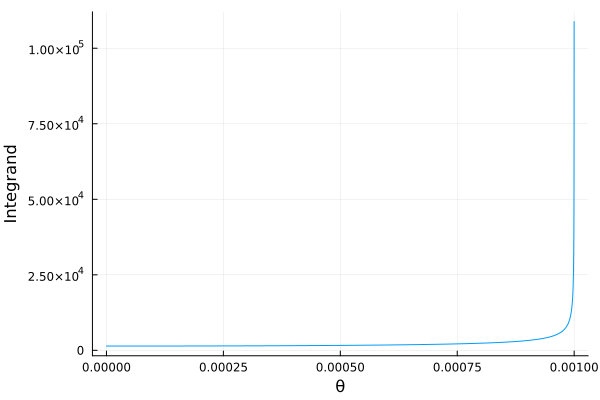

In [41]:
# My solution
thm=0.001
plot(th->1/sqrt(cos(th)-cos(thm)),0,thm,legend=false,xlabel="θ",ylabel="Integrand")

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 5
</h2>

The graph you just made has a singularity at $\theta=\theta_m$.  It turns out this means that our previous analysis of the convergence with $n$ is incorrect.  Repeat it for this integrand, at $\theta_m=0.001$, using the fact that for small angles the scaled period should be 1.

That is, we define $\bar T_n(\theta_m)$ as the integral evaluated with the midpoint rule with $n$ rectangles.  Plot $\mathrm{err}_n=1-\bar T_n(\theta_m)$ vs $n$ for $\theta_m=0.001$.  Either rescale the axes, or use a log-log plot to find out how $\mathrm{err}_n$ scales with $n$.

Note:  You may find it convenient to first define a function `tbar(thetam,n)` which calls `naive_midpoint` with the right arguments.

In [42]:
# my solution
tbar(thetam,n)=naive_midpoint(th->1/sqrt(cos(th)-cos(thetam)),(0,thetam),n)*sqrt(2)/(pi)

tbar (generic function with 1 method)

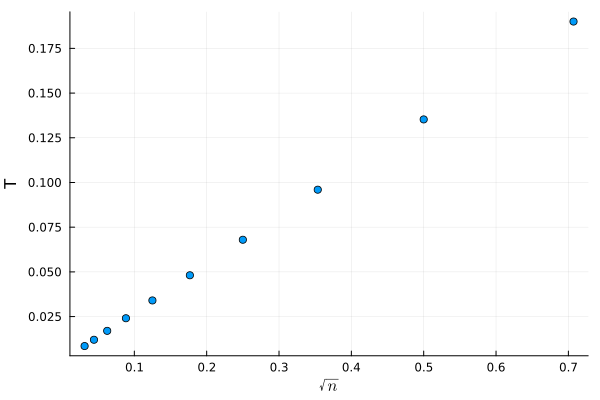

In [43]:
# My solution
nlist=[2^s for s in 1:10]
tblist=[tbar(0.001,n) for n in nlist]
scatter(1 ./sqrt.(nlist),1 .-tblist,xlabel=L"$\sqrt{n}$",ylabel="T",
    legend=false)

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 6
</h2>

Estimate what size of $n$ you would need to evaluate the integral with an accuracy of 1 part in $10^{-6}$?

In [44]:
# My solution
#We first fit our data
lf1=linearfit(log.(nlist),log.(abs.(tblist.-1)),(x->1.,x->x))

2-element Vector{Float64}:
 -1.3095829001740544
 -0.4983930036375717

That tells us that $\mathrm{err}_n=\exp(-1.3)/\sqrt{n}$.  So for a fixed error, $n=\exp(-2.6)/\mathrm{err}_n^2$.

In [45]:
# my solution
exp(-2.6)*10^12

7.427357821433388e10

my solution:
Thus we need something like $10^{11}$ evaluations.

# Change of Variables

Given the large number of evaluations that it would take to use the midpoint rule to evaluate this integral, it makes sense to do something smarter algorithmically.  We could try some sort of Richardson extrapolation, but there is a simpler approach:  A change of variables.

A good practice with any numerical integral is to first do a change of variable to get rid of any singularities.

In our case we want to evaluate the integral

$$
\bar T =\frac{\sqrt{2}}{\pi}\int_0^{\theta_m}\frac{d\theta}{\sqrt{\cos(\theta)-\cos(\theta_m)}}
$$

The integrand scales as $1/\sqrt{\theta_m-\theta}$ as $\theta\to\theta_m$.  Here are a few changes of variables which will eliminate that divergence:
\begin{align}
x &= \frac{\sqrt{\theta_m-\theta}}{\sqrt{\theta_m}}\\
\theta &= \theta_m \sin(z)
\end{align}

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 7
</h2>

1. Use one of these changes of variables (or another one that comes to mind for you), to transform this integral into one in which the integrand never diverges.  Do the arithmetic on a piece of paper, then make a function which corresponds to the integrand -- for example `integrandx(x,θₘ)` or `integrandz(z,θₘ)`.  Also make functions which return the upper and lower limits of the integral: `minx(θₘ)` and `maxx(θₘ)` or `minz(θₘ)` and `maxz(θₘ)`
2. Plot the integrand to verify that it is non-singular.  Try a few different values of `θₘ`

In [46]:
# my solution
integrandx(x,θₘ)=(2*sqrt(2)/pi)*x*θₘ/sqrt(cos(θₘ*(1-x^2))-cos(θₘ))
minx(θₘ)=0
maxx(θₘ)=1
##
integrandz(z,θₘ)=(sqrt(2)/pi)*θₘ*cos(z)/sqrt(cos(θₘ*sin(z))-cos(θₘ))
minz(θₘ)=0
maxz(θₘ)=pi/2

maxz (generic function with 1 method)

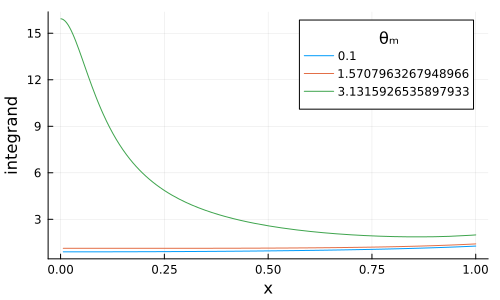

In [47]:
# my solution: x
tmlist=[0.1,pi/2,pi-0.01]
plt=plot(xlabel="x",ylabel="integrand",legendtitle="θₘ",size=(500,300))
for θₘ in tmlist
    plot!(x->integrandx(x,θₘ),minx(θₘ),maxx(θₘ),label=θₘ)
end
display(plt)

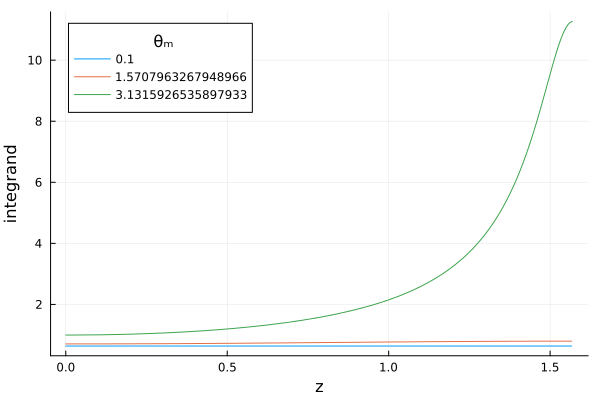

In [48]:
# my solution: z
tmlist=[0.1,pi/2,pi-0.01]
plt=plot(xlabel="z",ylabel="integrand",legendtitle="θₘ")
for tm in tmlist
    plot!(z->integrandz(z,tm),0,pi/2,label=tm)
end
display(plt)

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 8
</h2>

Make a function which takes `θₘ` and the number of rectangles `n`, and approximates our integral by calling `naive_midpoint`.  We will use this to check its convergence properties.

Verify that the function runs and gives sensible values.

In [49]:
# my solution
mytbarx(θₘ,n)=naive_midpoint(x->integrandx(x,θₘ),(minx(θₘ),maxx(θₘ)),n)
mytbarz(θₘ,n)=naive_midpoint(z->integrandz(z,θₘ),(minz(θₘ),maxz(θₘ)),n)

mytbarz (generic function with 1 method)

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 9
</h2>

Now we want to check the convergence properties of the numerical integral. Lets do this convergence check at  `θₘ=pi/2`.  Unfortunately we don't know the exact value of the integral at this point, so we can't just plot the error vs `n`, as we did before.

The solution is that we look at differences between successive approximations to the integral.  In particular, we look at $I_n-I_{n/2}$.  If $I_n\sim a+b n^{\alpha}$ then 
$$
I_n-I_{n/2}=b n^{\alpha} \left(1-\frac{1}{2^\alpha}\right)
$$
Thus a log-log plot of the successive differences will reveal the leading power with which the series is converging.

Note this also works with other ratios, not just factors of 2.  For example, if we use our `mid_data` object we naturally produce approximants for which `n` differs by powers of 3. 

1. Create the sequence $I_1,I_2,I_4,\cdots,I_{2^N}$, with $N$ of order $10$.  Feel free to use powers of 3 instead of powers of 2 if you like.
2. Create the sequence of differences $I_2-I_1,I_4-I_2,\cdots$.
3. Plot the log of the difference vs log(n).  Is it a straight line?  If so extract the power law.  If it is not a straight line, explain what is going on?  Be sure to label your axes.

Hint:  For step 2 you may find it useful to use the notation 
`dif=ilist[2:end]-ilist[1:end-1]`

Note:  The convergence properties will depend on which tranform you use.

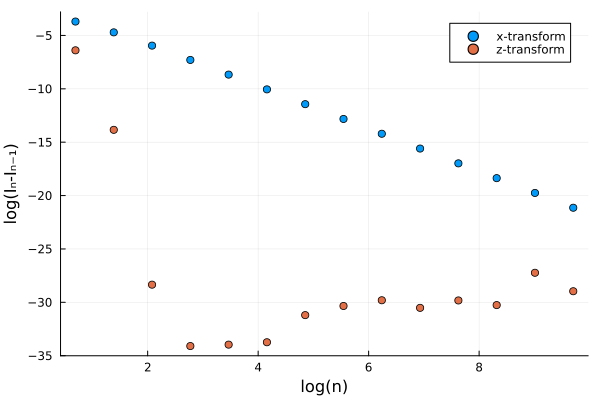

In [50]:
# my solution
nlist=[2^n for n in 0:14]
ixlist=[mytbarx(pi/2,n) for n in nlist]
izlist=[mytbarz(pi/2,n) for n in nlist]
difx= ixlist[2:end]-ixlist[1:end-1]
difz= izlist[2:end]-izlist[1:end-1]
scatter(log.(nlist[2:end]),log.(abs.(difx)),label="x-transform",xlabel="log(n)",ylabel="log(Iₙ-Iₙ₋₁)")
scatter!(log.(nlist[2:end]),log.(abs.(difz)),label="z-transform")

my solution

The x-transform looks linear -- this corresponds to a power law.  The z-transform is possibly linear at small n, but then turns flat.  What is happening here is that the integral is rapidly converging and we are hitting machine precision.

In [51]:
# my solution for extracting the power law from the x-data
linearfit(log.(nlist[2:end]),log.(abs.(difx)),(x->1.,x->x))

2-element Vector{Float64}:
 -1.9674295657428318
 -1.9667687094335433

my solution

this is consistent with a power law of n^-2

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 10
</h2>

Having established that the numerics are reliable, we can now do some physics.

Write a function which calls `nrmidpoint` to find the period as a function of `θₘ`.  Use that function to plot the period of a pendulum as a function of its maximum angle.

In [52]:
# my solution
Tx(θₘ)=nrmidpoint(x->integrandx(x,θₘ),(minx(θₘ),maxx(θₘ)))
Tz(θₘ)=nrmidpoint(z->integrandz(z,θₘ),(minz(θₘ),maxz(θₘ)))

Tz (generic function with 1 method)

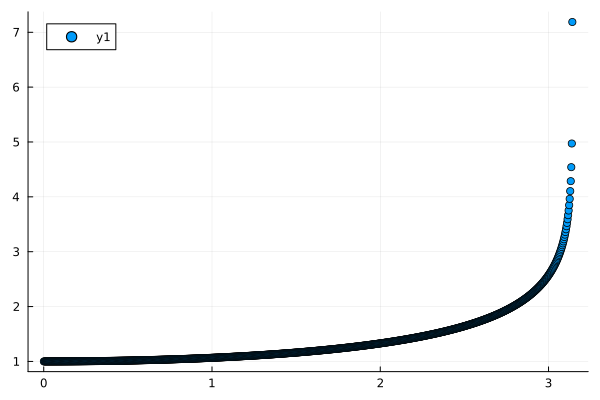

In [53]:
tmlist=range(0.001,pi-0.0001,1000)
TZlist=Tz.(tmlist)
TXlist=Tx.(tmlist)
scatter(tmlist,TZlist)

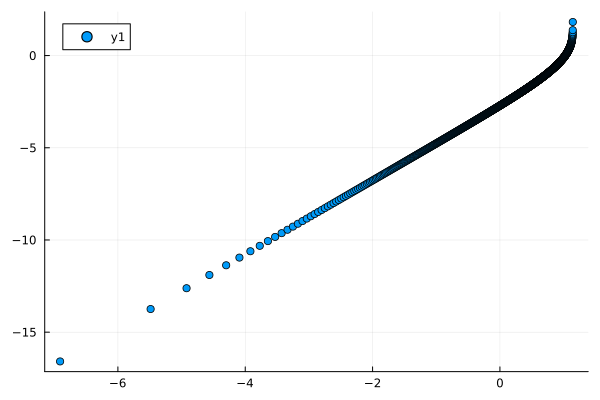

In [54]:
scatter(log.(tmlist),log.(abs.(TZlist.-1)))

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 11
</h2>

The period of a pendulum should diverge as $\theta_m\to \pi$.  Lets see if we can use our numerical experiment to figure out the form of the divergence.

Plot $\log(\bar T)$ as a function of $\log(\pi-\theta_m)$.  Is the result consistent with a power law?  If so, what is the power.

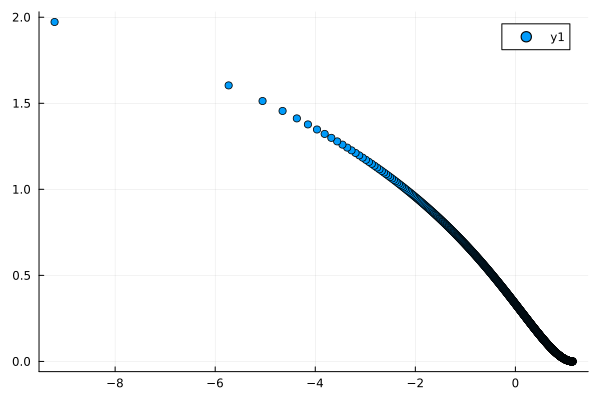

In [55]:
#my result
tmlist=range(0.001,pi-0.0001,1000)
TZlist=Tz.(tmlist)
TXlist=Tx.(tmlist)
scatter(log.(pi.-tmlist),log.(TZlist))

My answer:
I found that the result was not consistent with a power law.  Because the graph was not a straight line on a log-log plot

<h2 style="border: 2px solid #000; border-radius: 10px; padding: 20px; background-color:red; color:white;" >
## Activity 12
</h2>

You should have found that the divergence was not consistent with a power law.  It is in fact slower than any power law.  A good thing to try is a logarithm.  Plot $\bar T$ as a function of $\log(\pi-\theta_m)$.  Is the divergence logarithmic?

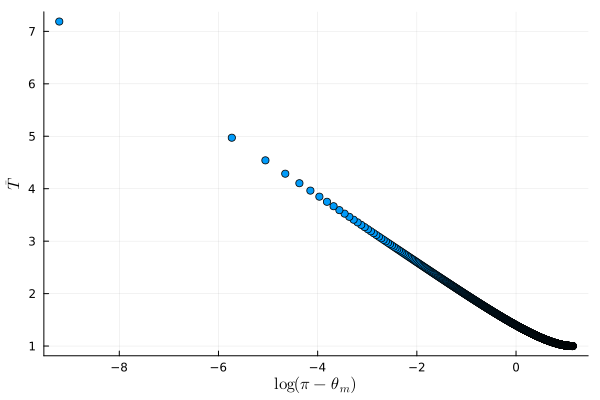

In [56]:
# my solution
scatter(log.(pi.-tmlist),TZlist,xlabel=L"$\log(\pi-\theta_m)$",ylabel=L"$\bar T$",
    legend=false)

my solution:

This looks like a straight line on the semi-log graph, so 
$$
\bar T \sim \log(\pi-\theta_m)
$$
as $\theta_m\to \pi$.

# Wrap-up

These activities have had several goals:
1. Learning how to write code in Julia
2. Learning about numerical integration
3. Learning how to work with numerical data, and draw conclusions from it
4. Learning about pendula

What, if any thoughts do you have about its success at these?  Was anything surprising?  Are you frustrated?  Was this exciting?

Write a paragraph below, expressing your thoughts.  Then make sure to scroll to the top and fill out the information about what resources you used.